# SparkMLlib-Titanic資料集實作
* 作者：JIH-KAI Lin 
* 以Kaggle Titanic資料集，判斷船難者是否存活
* 採用建模的方法：RandomForest/GBT
* 實作環境:python2.7/Spark2.2.0(with Hadoop2.7)

## Data Dictionary

#### Variable	Definition	Key
* survival	Survival	0 = No, 1 = Yes
* pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	Sex	
* Age	Age in years	
* sibsp	# of siblings / spouses aboard the Titanic	
* parch	# of parents / children aboard the Titanic	
* ticket	Ticket number	
* fare	Passenger fare	
* cabin	Cabin number	
* embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

#### Variable Notes

* pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## 1. 使用numpy、pandas進行資料前處理

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

In [2]:
# load data with pd
train_df = pd.read_csv('kaggle-Titanic/train.csv')
test_df = pd.read_csv('kaggle-Titanic/test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [5]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [9]:
train_df.Sex.unique()

array(['male', 'female'], dtype=object)

In [10]:
train_df.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

### 小結1
* Age/Cabin/Embarker have null value
* Name/Sex/Ticket/Cabin/Embarked are objects.
* SlibSp/Parch的資料分布極不平均
* Fare有離群值
* Sex/Embarked適合轉換成int型資料以利後續處理

## 2. 以seaborn、matplotlib資料視覺化

In [11]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt

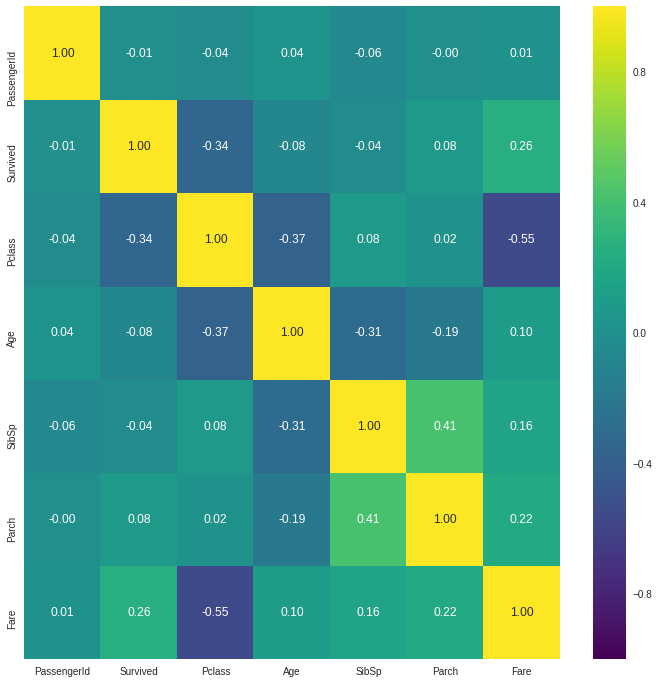

In [12]:
traindfCorr = train_df.corr()
plt.figure(figsize=[12,12]) #we only plot correlation between what we think are the best features
sns.heatmap(traindfCorr, annot=True, fmt=".2f", cmap='viridis')
plt.show()

In [13]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [14]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [15]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [16]:
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


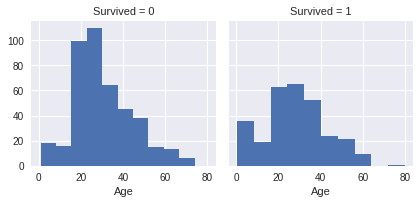

In [17]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age')
plt.show()

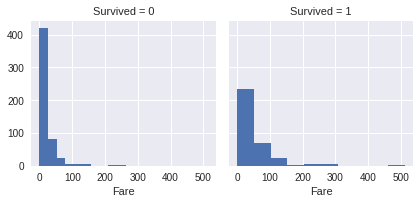

In [18]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Fare')
plt.show()

### 小結2
* By Heatmap, Survived are related to Pclass and Fare.
* Pclass=1 存活率最高
* Fare越高越容易存活

## 3. 進行資料型別轉換-Sex/Embarked

In [19]:
train_df['Sex'] = train_df['Sex'].map( {'male': 1, 'female': 0} ).astype(int)
test_df['Sex'] = test_df['Sex'].map( {'male': 1, 'female': 0} ).astype(int)
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)

In [20]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,S


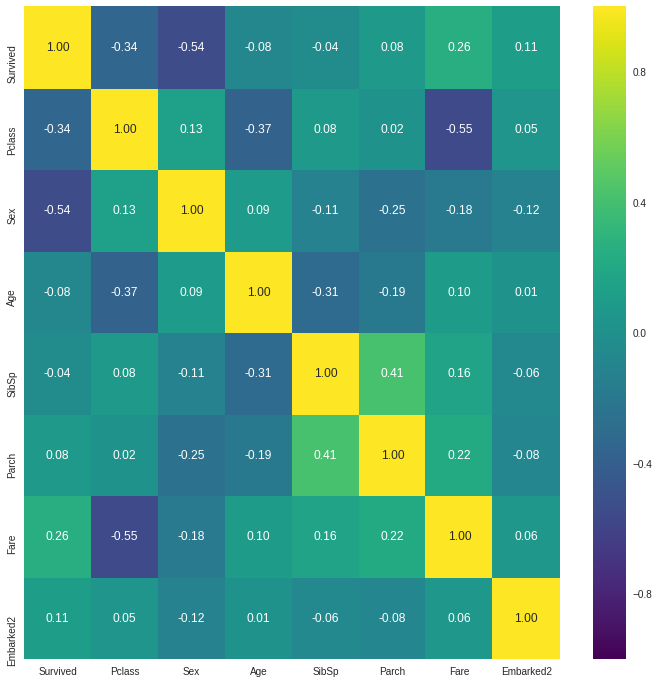

In [21]:
train_df = train_df.drop(['PassengerId'], axis=1)
test_df = test_df.drop(['PassengerId'], axis=1)

train_df['Embarked2'] = train_df['Embarked']
test_df['Embarked2'] = test_df['Embarked']

train_df.Embarked2.fillna('S',inplace=True)
test_df.Embarked.fillna('S',inplace=True)

test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

train_df['Embarked2'] = train_df['Embarked2'].map( {'S': 1, 'C': 2, 'Q': 3} ).astype(int)
test_df['Embarked2'] = test_df['Embarked2'].map( {'S': 1, 'C': 2, 'Q': 3} ).astype(int)

traindfCorr2 = train_df.corr()
plt.figure(figsize=[12,12]) #we only plot correlation between what we think are the best features
sns.heatmap(traindfCorr2, annot=True, fmt=".2f", cmap='viridis')
plt.show()

In [22]:
train_df['Embarked'] = train_df['Embarked2']
train_df = train_df.drop(['Embarked2'], axis=1)
test_df['Embarked'] = test_df['Embarked2']
test_df = test_df.drop(['Embarked2'], axis=1)
train_df = train_df.drop(['Name','Age','SibSp','Parch'], axis=1)
test_df = test_df.drop(['Name','Age','SibSp','Parch'], axis=1)

train_df.head()

,Survived,Pclass,Sex,Fare,Embarked
0,0,3,1,7.2500,1
1,1,1,0,71.2833,2
2,1,3,0,7.9250,1
3,1,1,0,53.1000,1
4,0,3,1,8.0500,1


In [23]:
test_df.head()

,Pclass,Sex,Fare,Embarked
0,3,1,7.8292,3
1,3,0,7.0000,1
2,2,1,9.6875,3
3,3,1,8.6625,1
4,3,0,12.2875,1


### 小結3
* We converted Sex and Embarked from objects to int.
* By Heatmap, Sex is the best feature with Survived and we drop Name/Age/SibSp/Parch in train/test dataframe.

### 4. 使用SparkSQL進行建模前的預處理
* MLlib處理有兩種格式RDD、dataframe，此處採用dataframe的格式應此用sparkSQL進行格式轉換

In [24]:
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext('local[*]')
sqlContext = SQLContext(sc)

In [25]:
#將train/test data轉成spark.dataframe格式
train_sql = sqlContext.createDataFrame(train_df)
type(train_sql)

pyspark.sql.dataframe.DataFrame

In [26]:
train_sql.take(5)

[Row(Survived=0, Pclass=3, Sex=1, Fare=7.25, Embarked=1),
 Row(Survived=1, Pclass=1, Sex=0, Fare=71.2833, Embarked=2),
 Row(Survived=1, Pclass=3, Sex=0, Fare=7.925, Embarked=1),
 Row(Survived=1, Pclass=1, Sex=0, Fare=53.1, Embarked=1),
 Row(Survived=0, Pclass=3, Sex=1, Fare=8.05, Embarked=1)]

In [27]:
test_sql = sqlContext.createDataFrame(test_df)

In [28]:
test_sql.take(5)

[Row(Pclass=3, Sex=1, Fare=7.8292, Embarked=3),
 Row(Pclass=3, Sex=0, Fare=7.0, Embarked=1),
 Row(Pclass=2, Sex=1, Fare=9.6875, Embarked=3),
 Row(Pclass=3, Sex=1, Fare=8.6625, Embarked=1),
 Row(Pclass=3, Sex=0, Fare=12.2875, Embarked=1)]

In [29]:
#觀看各個feature在spark.dataframe裡面的格式
train_sql.dtypes

[('Survived', 'bigint'),
 ('Pclass', 'bigint'),
 ('Sex', 'bigint'),
 ('Fare', 'double'),
 ('Embarked', 'bigint')]

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [31]:
#將資料型態轉成帶有label的DenseVector格式,test沒有label補0
from pyspark.ml.linalg import Vectors, VectorUDT
def f2Lp(inStr):
    return (float(inStr[0]), Vectors.dense(inStr[1],inStr[2],inStr[3],inStr[4]))
Lp = train_sql.rdd.map(f2Lp)
def ttv(inStr):
    return (0,Vectors.dense(inStr[0],inStr[1],inStr[2],inStr[3]))
Lp2 = test_sql.rdd.map(ttv)

In [32]:
trainDF=sqlContext.createDataFrame(Lp,["label","features"])
testDF=sqlContext.createDataFrame(Lp2,["testlabe","features"])

In [33]:
trainDF.take(5)

[Row(label=0.0, features=DenseVector([3.0, 1.0, 7.25, 1.0])),
 Row(label=1.0, features=DenseVector([1.0, 0.0, 71.2833, 2.0])),
 Row(label=1.0, features=DenseVector([3.0, 0.0, 7.925, 1.0])),
 Row(label=1.0, features=DenseVector([1.0, 0.0, 53.1, 1.0])),
 Row(label=0.0, features=DenseVector([3.0, 1.0, 8.05, 1.0]))]

In [34]:
testDF.take(5)

[Row(testlabe=0, features=DenseVector([3.0, 1.0, 7.8292, 3.0])),
 Row(testlabe=0, features=DenseVector([3.0, 0.0, 7.0, 1.0])),
 Row(testlabe=0, features=DenseVector([2.0, 1.0, 9.6875, 3.0])),
 Row(testlabe=0, features=DenseVector([3.0, 1.0, 8.6625, 1.0])),
 Row(testlabe=0, features=DenseVector([3.0, 0.0, 12.2875, 1.0]))]

In [36]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(trainDF)
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(trainDF)

### 5. 建模-RandomForest/GBT

In [38]:
#將traimData切分建立驗證資料集
(trainingData, testData) = trainDF.randomSplit([0.7, 0.3])

#### RandomForest建模

In [39]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])
model = pipeline.fit(trainingData)

In [40]:
#對驗證集進行預測
predictions = model.transform(testData)

In [41]:
#對比預測和實際情形
predictions.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|   [1.0,1.0,0.0,1.0]|
|       0.0|         0.0|  [1.0,1.0,26.0,1.0]|
|       0.0|         0.0|[1.0,1.0,27.7208,...|
|       0.0|         0.0|[1.0,1.0,27.7208,...|
|       0.0|         0.0|  [1.0,1.0,29.7,2.0]|
+----------+------------+--------------------+
only showing top 5 rows



In [42]:
#針對驗證集計算RandomForest的準確率
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.762845849802


In [43]:
#對要預測的test data進行預測
predictions = model.transform(testDF)

In [44]:
#將預測結果轉換成最後提交的格式
result = pd.read_csv('kaggle-Titanic/test.csv')
result = result[['PassengerId','Pclass']]
y_prid = predictions.select("prediction").toPandas()
result['Pclass'] = y_prid

In [45]:
result.head()

,PassengerId,Pclass
0,892,0.0
1,893,1.0
2,894,0.0
3,895,0.0
4,896,1.0


In [46]:
result.rename(columns={'PassengerId': 'PassengerId', 'Pclass': 'Survived'}, inplace=True)

In [47]:
result.head()

,PassengerId,Survived
0,892,0.0
1,893,1.0
2,894,0.0
3,895,0.0
4,896,1.0


In [48]:
#將結果寫成csv檔案
result.to_csv('SparkRF.csv', encoding='utf-8', index=False)

#### GBT建模

In [49]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [50]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.790513833992


In [51]:
predictions = model.transform(testDF)
result = pd.read_csv('kaggle-Titanic/test.csv')
result = result[['PassengerId','Pclass']]
y_prid = predictions.select("prediction").toPandas()
result['Pclass'] = y_prid
result.rename(columns={'PassengerId': 'PassengerId', 'Pclass': 'Survived'}, inplace=True)
result.to_csv('SparkGBT.csv', encoding='utf-8', index=False)

### 6. 結果
* Spark RandomForest 0.78468
* Spark GBT          0.76555